In [1]:
import os
from transformers import DetrImageProcessor, DetrForObjectDetection, DetrFeatureExtractor, DetrConfig
import torch
from torch.utils.data import DataLoader
import torchvision
from PIL import Image, ImageDraw
import pytorch_lightning as pl
import numpy as np
from pytorch_lightning import Trainer
import pandas as pd

In [58]:
# Split the dataset into train and validation
train_ds = pd.read_csv("RebarDSC/images/annotations/100_percent_train.csv", header=None)
name_list = train_ds[0].unique()
np.random.shuffle(name_list)

name_list_train, name_list_val = np.split(name_list, [int(.8*len(name_list))])
train_set = train_ds[train_ds[0].isin(name_list_train)]
val_set = train_ds[train_ds[0].isin(name_list_val)]
train_set.to_csv("RebarDSC/images/annotations/train.csv", index=False, header=False)
val_set.to_csv("RebarDSC/images/annotations/val.csv", index=False, header=False)


In [2]:
# Convert CSV to COCO format
        # We need to convert the CSV to a JSON format like that:
        # annotation{
        # "id" : int, "image_id" : int, "category_id" : int, "segmentation" : RLE or [polygon], "area" : float, "bbox" : [x,y,width,height], "iscrowd" : 0 or 1,
        # }
        # 
        # categories[{
        # "id" : int, "name" : str, "supercategory" : str,
        # }]

def convert_csv_to_coco(csv_path, img_path, json_path):
  import csv
  import json
  from collections import defaultdict

  # Create the categories
  categories = []
  categories.append({"id": 0, "name": "background", "supercategory": ""})
  categories.append({"id": 1, "name": "rebar", "supercategory": ""})

  # Create the annotations
  annotations = []
  images = []
  image_ids = []
  annotation_id = 0
  with open(csv_path, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        # row contains the follwing information [image_name, xmin ymin xmax ymax]
        # print(row)
        image_name = row[0]
        coordinates = row[1].split(" ")
        xmin = float(coordinates[0])
        ymin = float(coordinates[1])
        xmax = float(coordinates[2])
        ymax = float(coordinates[3])
        area = (xmax -xmin) * (ymax - ymin)
        # Extract the image id from the image name
        image_id = int(image_name.split("_")[1])
        annotations.append({"id": annotation_id, "image_id": image_id, "category_id": 1, "segmentation": [], "area": area,
                            "bbox": [xmin, ymin, xmax -xmin,ymax-ymin], "iscrowd": 0})
  
  # Create the images
        if image_id not in image_ids:
            image_ids.append(image_id)
            # Get the image size
            image = Image.open(os.path.join(img_path, image_name))
            width, height = image.size
            images.append({"id": image_id, "width": width, "height": height, "file_name": image_name})

  # Create the JSON
  data = {"info": {}, "licenses": {}, "images": images, "annotations": annotations, "categories": categories}
  with open(json_path, 'w') as outfile:
    json.dump(data, outfile)


In [59]:
# Convert the CSV to COCO format
convert_csv_to_coco("RebarDSC/images/annotations/train.csv", "RebarDSC/images", "RebarDSC/images/annotations/train.json")
convert_csv_to_coco("RebarDSC/images/annotations/val.csv", "RebarDSC/images", "RebarDSC/images/annotations/val.json")
convert_csv_to_coco("RebarDSC/images/annotations/test.csv", "RebarDSC/images", "RebarDSC/images/annotations/test.json")

In [60]:
# Create the Data loader
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, mode='train'):
        assert mode in ['train', 'val', 'test'],  f'Unknown mode: {mode}'
        ann_file = os.path.join(img_folder, f"annotations/{mode}.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


In [61]:
# Set up pre-trained model
pretrained_model = "facebook/detr-resnet-50"

img_folder = "RebarDSC/images"

feature_extractor = DetrFeatureExtractor.from_pretrained(pretrained_model)

train_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='train')
val_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='val')
test_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, mode='test')

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


In [62]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 900
Number of validation examples: 225
Number of test examples: 1000


Image n°1281


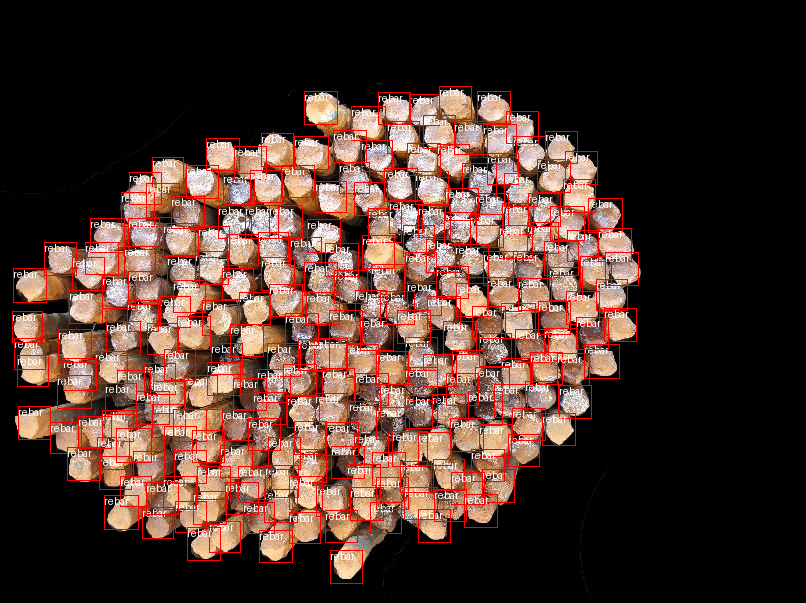

In [7]:
# Let's check one example

image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [14]:
# Create the data loaders
def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2, num_workers=0)
batch = next(iter(train_dataloader))

In [9]:
# Let's check the batch
print(batch.keys())
pixel_values, target = train_dataset[0]
print(pixel_values.shape)
print(target)

dict_keys(['pixel_values', 'pixel_mask', 'labels'])
torch.Size([3, 934, 800])
{'size': tensor([934, 800]), 'image_id': tensor([0]), 'class_labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1]), 'boxes': tensor([[0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0.0363, 0.0301],
        [0.8331, 0.5033, 0

In [10]:
# We define our model based on DETR
class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained(pretrained_model, 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [11]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [42]:
trainer = Trainer(max_steps=100, gradient_clip_val=0.1)
trainer.fit(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.008   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/homebrew/Caskroom/miniforge/base/envs/py311/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 12.54 GB, other allocations: 23.73 GB, max allowed: 36.27 GB). Tried to allocate 6.41 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

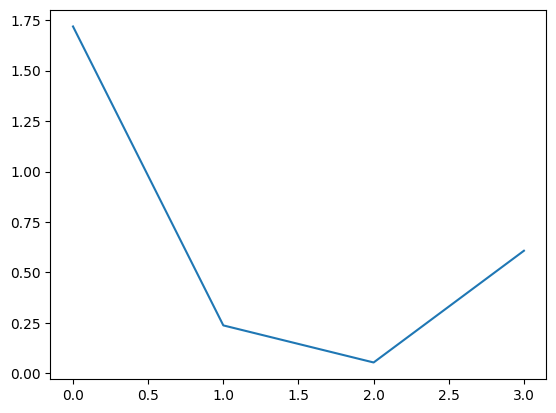

In [20]:
# Get statistics about the training
import matplotlib.pyplot as plt
metrics = trainer.callback_metrics
losses = [v for k,v in metrics.items() if "loss" in k]
plt.plot(losses)
plt.show()


In [21]:
# Get accuracy on the validation set
trainer.validate(model)

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
# Run the inference
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model.to(device)
model.eval()

Detr(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(64, 256

In [23]:
def count_rebar(outputs, threshold=0.7):
  # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

  # return the count of rebar
    return len(probas[keep])

In [36]:
# Get count from the CSV file
res = pd.read_csv("RebarDSC/images/annotations/test.csv", header=None)
res.columns = ["image_name", "bbox"]
res["image_id"] = res["image_name"].apply(lambda x: int(x.split("_")[1]))
# Get the count of rebar per image_id
res = res.groupby("image_id").count().reset_index()
res = res[["image_id", "bbox"]]
res.columns = ["image_id", "count"]
res

,image_id,count
0,1,245
1,3,46
2,5,232
3,9,199
4,16,272
...,...,...
995,2117,149
996,2118,280
997,2121,174
998,2123,266


In [24]:
# Get the predictions
pred_res = pd.DataFrame(columns=["image_id", "pred_count"])
it = iter(range(len(test_dataset)))
pixel_values, target = test_dataset[next(it)]

pixel_values = pixel_values.unsqueeze(0).to(device)
print(pixel_values.shape)
outputs = model(pixel_values=pixel_values, pixel_mask=None)
image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
pred_count = count_rebar(outputs, threshold=0.5)
pred_res = pred_res.loc[len(pred_res)] = [image_id, pred_count]

torch.Size([1, 3, 800, 1066])


100

In [41]:
# Merge the predictions with the ground truth
res = res.merge(pred_res, on="image_id")